In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

In [2]:
'''Over All Variables'''
x_step = 50
y_step = 10
train_rate = 0.7
csv_path = "KRW-BTC_1.csv"
dividing = 10000
number_of_feature = 2

In [3]:
'''Get Dataset from csv'''
dataframe = pd.read_csv(csv_path)

volume = dataframe['volume'].values
price = dataframe['price'].values / dividing

In [4]:
def moving_average(data, window_size):
    # 주어진 윈도우 크기에 따라 가중치를 생성
    weights = np.repeat(1.0, window_size) / window_size

    # 이동 평균 계산
    moving_avg = np.convolve(data, weights, 'valid')

    return moving_avg

price = moving_average(price, 10)
volume = np.delete(volume, (1,2,3,4,5,6,7,8,9))

In [5]:
minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()

volume = volume.reshape(-1, 1)
volume = minmax_scaler.fit_transform(volume)
price = price.reshape(-1, 1)

data = np.concatenate((price, volume), axis=1)

train = data[:round(len(data)*train_rate)]
test = data[round(len(data)*train_rate):]

price_train = price[:round(len(price)*train_rate)]
price_test = price[round(len(price)*train_rate):]

In [6]:
train_x = []
train_y = []

test_x = []
test_y = []

for i in range(0, len(train), (x_step//6)):
    train_x.append(train[i : i+x_step])
    train_y.append(price_train[i+x_step : i+x_step+y_step])

for i in range(0, len(test), (x_step//6)):
    test_x.append(test[i : i+x_step])
    test_y.append(price_test[i+x_step : i+x_step+y_step])
    
for i in range(len(train_x), len(train_x)-x_step, -1):
    if (train_x[i-1].shape[0] != x_step) or (train_y[i-1].shape[0] != y_step) :
        del train_x[i-1]
        del train_y[i-1]

for i in range(len(test_x), len(test_x)-x_step, -1):
    if (test_x[i-1].shape[0] != x_step) or (test_y[i-1].shape[0] != y_step) :
        del test_x[i-1]
        del test_y[i-1]

train_x = np.array(train_x)
train_y = np.array(train_y).reshape(-1, y_step)
test_x = np.array(test_x)
test_y = np.array(test_y).reshape(-1, y_step)

In [7]:
'''minmax scaling in each timestep'''
'''hadamard product in each timestep'''

hadamard = np.array([i/x_step + 1 for i in range(1, x_step+1)])

'''hadamard'''
# for i in range(len(train_x)):
#     train_x[i][:, 0] = train_x[i][:, 0] * hadamard

# for i in range(len(test_x)):
#     test_x[i][:, 0] = test_x[i][:, 0] * hadamard

'''minmax'''
for i in range(len(train_x)):
    # train_x[i][:, 1] = minmax_scaler.fit_transform(train_x[i][:, 1].reshape(-1, 1)).reshape(x_step) * hadamard
    train_x[i][:, 0] = minmax_scaler.fit_transform(train_x[i][:, 0].reshape(-1, 1)).reshape(x_step)
    train_y[i] = minmax_scaler.transform(train_y[i].reshape(-1, 1)).reshape(y_step)

for i in range(len(test_x)):
    # test_x[i][:, 1] = minmax_scaler.fit_transform(test_x[i][:, 1].reshape(-1, 1)).reshape(x_step)
    test_x[i][:, 0] = minmax_scaler.fit_transform(test_x[i][:, 0].reshape(-1, 1)).reshape(x_step)
    test_y[i] = minmax_scaler.transform(test_y[i].reshape(-1, 1)).reshape(y_step)

In [8]:
model = Sequential()

model.add(Bidirectional(LSTM(units=100, return_sequences=True)))
model.add(Bidirectional(LSTM(units=100)))
model.add(Dense(y_step))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.fit(train_x, train_y, epochs=10, batch_size=128)

Epoch 1/10
2238/2238 [==============================] - 51s 20ms/step - loss: 0.0800 - mae: 0.1605
Epoch 2/10
2238/2238 [==============================] - 45s 20ms/step - loss: 0.0662 - mae: 0.1409
Epoch 3/10
2238/2238 [==============================] - 44s 20ms/step - loss: 0.0649 - mae: 0.1385
Epoch 4/10
2238/2238 [==============================] - 44s 20ms/step - loss: 0.0645 - mae: 0.1377
Epoch 5/10
2238/2238 [==============================] - 45s 20ms/step - loss: 0.0639 - mae: 0.1370
Epoch 6/10
2238/2238 [==============================] - 45s 20ms/step - loss: 0.0633 - mae: 0.1361
Epoch 7/10
2238/2238 [==============================] - 47s 21ms/step - loss: 0.0630 - mae: 0.1355
Epoch 8/10
2238/2238 [==============================] - 47s 21ms/step - loss: 0.0625 - mae: 0.1345
Epoch 9/10
2238/2238 [==============================] - 47s 21ms/step - loss: 0.0620 - mae: 0.1339
Epoch 10/10
2238/2238 [==============================] - 47s 21ms/step - loss: 0.0619 - mae: 0.1338


3837/3837 [==============================] - 27s 7ms/step


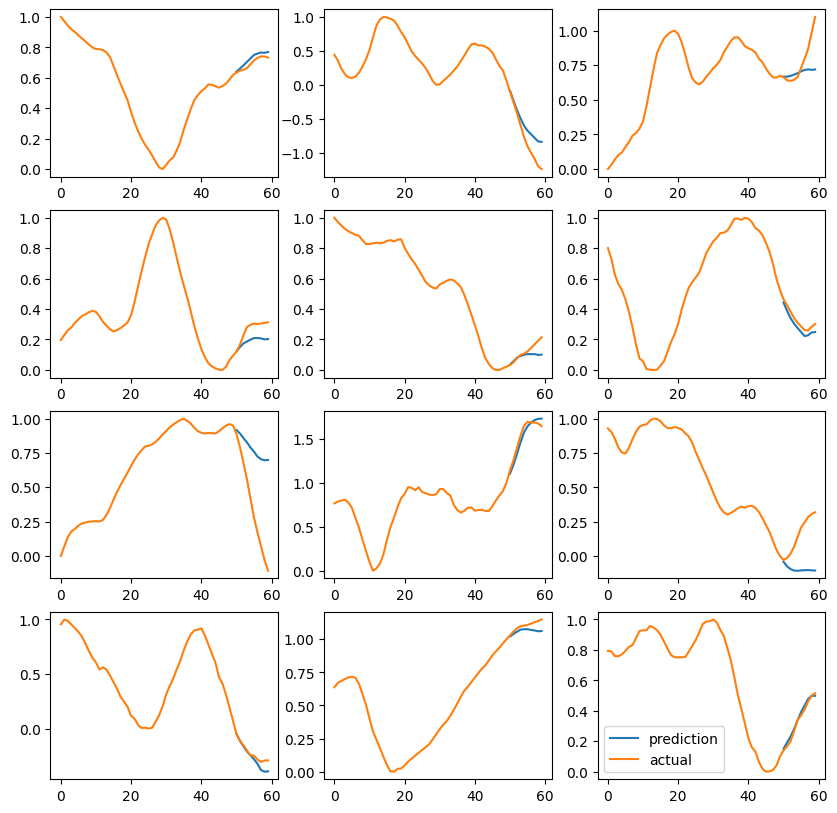

In [9]:
prediction = model.predict(test_x)

plt.figure(figsize=(10,10))
for i in range(1, 13):
    plt.subplot(4, 3, i)
    plt.plot(np.append([np.nan]*x_step, prediction[i*500]))
    plt.plot(np.append(test_x[i*500][:, 0], test_y[i*500]))
    # plt.plot(prediction[i*500], label='Prediction')
    # plt.plot(test_y[i*500], label='Actual')

plt.legend(['prediction', 'actual'])
plt.show()

In [10]:
model.save('model0118/model.h5')

1/1 [==============================] - 0s 24ms/step


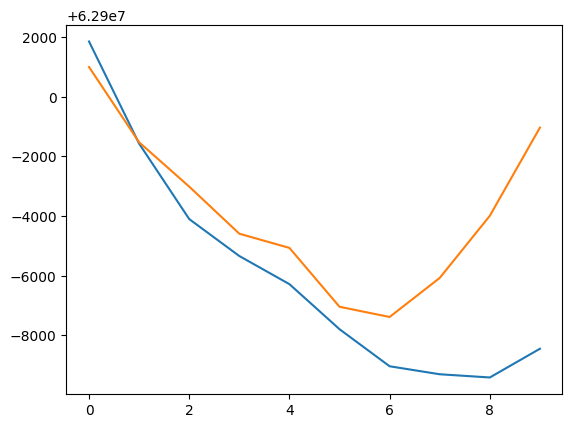

In [47]:
index = 2_00
prediction = model.predict(np.array([test_x[index]]))
plt.plot(minmax_scaler.inverse_transform(prediction).flatten()*10000)
plt.plot((minmax_scaler.inverse_transform(test_y[index].reshape(-1, 1))*10000).flatten())
plt.show()